In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image, ImageOps
import os
import json
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import torch.optim as optim

import cv2

import random
import numpy as np
    
import matplotlib.pyplot as plt

In [57]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [58]:
# Dataset do složky DataSet -- Dataset1
#                           |- Dataset2

# Rozdělit Dataset na 2-3 Train, Test, Validation
# Validation je až poslední
# shuffle data
# balance data nemít 40% stejnou ground truth (tohle je asi u classifierů)

#### DEFINE DataLoader ####


class data(Dataset):
    def __init__(self, path):
        self.len = 2000
        convert_tensor = transforms.ToTensor()
        convert_float = transforms.ConvertImageDtype(torch.float)
        src = cv2.imread('D:\Skola\ITT\Repository\SideStandB.png', cv2.IMREAD_GRAYSCALE)
        dst = cv2.imread('D:\Skola\ITT\Repository\SideStandC.png', cv2.IMREAD_GRAYSCALE)

        self.Items = []

        for k in range(0,self.len):
            # generate random transform matrix
            # translationX = 0
            translationX = random.uniform(50, 150) * random.choice([1, -1])

            originalTransfrom = np.mat([[1., 0., 130], [0., 1., 52.], [0., 0., 1.]] , dtype=np.float32)
            GeneratedShfit = np.mat([[1., 0., translationX], [0., 1., 0.], [0., 0., 1.]] , dtype=np.float32)
            InvertedGeneratedShfit = np.mat([[1., 0., -translationX], [0., 1., 0.], [0., 0., 1.]] , dtype=np.float32)

            GeneratedTransform = np.matmul(originalTransfrom, InvertedGeneratedShfit)

            # conver matrix to points
            points = [ [0, 0, 1], [1440, 1440, 1], [0, 1440, 1], ]
            warpedPoints = np.matmul(points, GeneratedTransform.transpose(),  dtype=np.float32)

            # image processing
            warped = cv2.warpAffine(src, GeneratedShfit[0:-1, : ], (1440, 1440))

            warped = cv2.resize(warped, (128, 128))
            dst = cv2.resize(dst, (128, 128))

            # return values
            stacked = torch.stack((convert_tensor(dst), convert_tensor(warped)))
            self.Items.append((stacked, torch.from_numpy(warpedPoints[:, 0:-1].flatten() ) ))

    # the function returns length of data
    def __len__(self):
        return self.len

    # gives one item at a time
    def __getitem__(self, index):
        return self.Items[index]


In [59]:
#### DEFINE Neural Network ####
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self._to_linear = None

        # 2 input image channel, 64 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.fc9 = nn.Linear(16384, 1024)

        self.fc10 = nn.Linear(1024, 6)

    def convs(self, x):
        # max pooling over 2x2
        # two conv layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
            
        return x

    def forward(self, x):

        x = self.convs(x)
        x = x.view(-1, x[0].shape[0] * x[0].shape[1] * x[0].shape[2])

        # two linear layers
        x = F.relu(self.fc9(x))
        x = self.fc10(x)
        
        return x


In [60]:
#### Create data ####

Dataset = data('testingML.png')
train_set, val_set = torch.utils.data.random_split(Dataset, [1800,200])
train_dataloader = DataLoader(train_set, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=1, shuffle=True)

net = Net()

loss_function = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.1)

Epochs = 2
# Learning
for epoch in range(Epochs):
    for dataBatch in train_dataloader:
        Images, groundTruths = dataBatch

        optimizer.zero_grad()

        outputs = net(Images.view(-1, 2, 128, 128)) 

        loss = loss_function(outputs, groundTruths.view(-1,6))
        loss.backward() 
        optimizer.step() 
    # Training
    print(f"Epoch: {epoch}. Loss: {loss}")

Epoch: 0. Loss: 32366.63671875
Epoch: 1. Loss: 4429.6796875


In [61]:
iterations = []
with torch.no_grad():
        for dataBatch in val_dataloader:
                Images, groundTruths = dataBatch
                outputs = net(Images.view(-1, 2, 128, 128)) 

                loss = loss_function(outputs, groundTruths.view(-1,6))
                iterations.append({ "batch": dataBatch, "outputs":outputs, "loss": loss})

Ground Truth :
 [[ 202.648   52.   ]
 [1642.648 1492.   ]
 [ 202.648 1492.   ]]
Transofrm    :
 [[ 136.394   39.711]
 [1574.33  1503.904]
 [ 122.724 1498.042]]
loss: 2629.02978515625


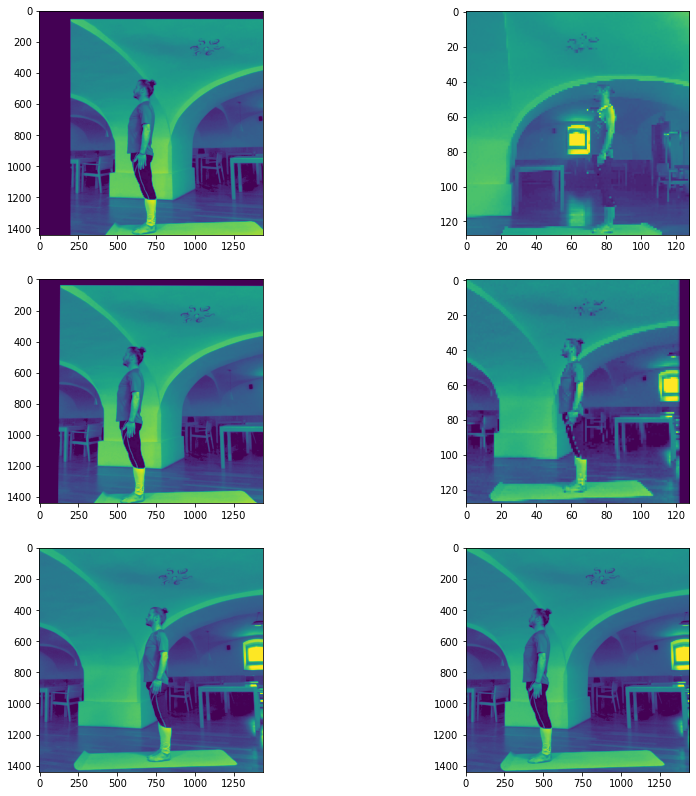

In [62]:
iteration = random.choice(iterations)
im, gt = iteration["batch"]

np.set_printoptions(precision=3, suppress=True)

print(f"Ground Truth :\n {np.array(gt[0].view(3,2))}")
print(f"Transofrm    :\n {np.array(iteration['outputs'][0].view(3,2))}")
print(f"loss: {iteration['loss']}")

src = cv2.imread('..\SideStandB.png', cv2.IMREAD_GRAYSCALE)
dst = cv2.imread('..\SideStandC.png', cv2.IMREAD_GRAYSCALE)

groundPoints = np.array(gt.view(3,2))
# groundPoints = np.concatenate( (groundPoints, [[1], [1], [1],]), axis=1)

outputPoints = np.array(iteration['outputs'][0].view(3,2))
# outputPoints = np.concatenate( (outputPoints, [[1], [1], [1],]), axis=1)

srcPoints = np.array([ [0, 0], [1440, 1440], [0, 1440], ]).astype(np.float32)

fig, axes = plt.subplots(3, 2, figsize=(14, 14))

axes[2][1].imshow(src)
axes[2][0].imshow(dst)

# Ground Truth
gtTransform = cv2.getAffineTransform(srcPoints, groundPoints)
warped = cv2.warpAffine(src, gtTransform, (1440, 1440))

axes[0][0].imshow(warped)

# Network Result
outputTransform = cv2.getAffineTransform(srcPoints, outputPoints)
warped = cv2.warpAffine(src, outputTransform, (1440, 1440))

axes[1][0].imshow(warped)

# Network Imputs
axes[0][1].imshow(im[0][0].view(128,128))

axes[1][1].imshow(im[0][1].view(128,128))

